# MNIST Digit Classification Using Perceptron Learning Algorithm (PLA)

**Objective**:  
This notebook compares the performance of two variants of the Perceptron Learning Algorithm (PLA) on the MNIST digit classification task:
- **Clean PLA**: Standard perceptron without enhancements.
- **Pocket PLA**: Enhanced perceptron that stores the best-performing weights.

**Dataset**:  
- MNIST dataset (60,000 training samples and 10,000 test samples).
- Images normalized to range [0, 1] and bias term added.

**Evaluation Metrics**:  
- Confusion matrices
- Overall accuracy (ACC)
- Sensitivity (True Positive Rate - TPR) for each digit class
- Training and testing error curves for detailed iteration analysis

**Goals**:  
- Evaluate and compare model accuracy and robustness between Clean and Pocket PLA.
- Visualize and analyze model performance in depth.


In [1]:
%%capture run_output
%matplotlib inline
import sys
import os

# Assuming 'notebooks/' is one folder below your project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt

from core.logger.config import logger
from core.data.mnist_loader import load_mnist
from core.data.data_preprocessing import preprocess_data
from core.models.perceptron.multi_class_perceptron import MultiClassPerceptron
from core.analysis.evaluation_functions import evaluate_model
from core.analysis.plotting import plot_error_curves

# Ensure results directories exist
os.makedirs("results/perceptron_results/clean", exist_ok=True)
os.makedirs("results/perceptron_results/pocket", exist_ok=True)


## 1. Load and Preprocess the MNIST Dataset

We'll load the MNIST dataset using our custom loader (`mnist_loader`) and then apply preprocessing (`data_preprocessing`), which normalizes each image to [0,1] and adds a bias term.

In [2]:
from core.data.mnist_loader import load_mnist
from core.data.data_preprocessing import preprocess_data
# Load raw MNIST data (X: images, y: labels)
X_raw, y_raw = load_mnist()

print("Raw MNIST data shapes:")
print("X_raw:", X_raw.shape, "y_raw:", y_raw.shape)

# Preprocess (normalize & add bias = True)
X = preprocess_data(X_raw, add_bias=True, normalize=True)
print("Preprocessed shape:", X.shape)

# Split into train/test manually or with 60k/10k as the task suggests
X_train, y_train = X[:60000], y_raw[:60000]
X_test,  y_test  = X[60000:], y_raw[60000:]
print("Train set:", X_train.shape, y_train.shape)
print("Test set: ", X_test.shape,  y_test.shape)


Raw MNIST data shapes:
X_raw: (70000, 784) y_raw: (70000,)
Preprocessed shape: (70000, 785)
Train set: (60000, 785) (60000,)
Test set:  (10000, 785) (10000,)


## 2. Train Clean vs Pocket Perceptron

We instantiate our `MultiClassPerceptron` in **clean** (no-pocket) mode and **pocket** mode, train each one on the MNIST training set, and evaluate on the test set.


In [ ]:
import time
from core.logger.config import logger
from core.models.perceptron.multi_class_perceptron import MultiClassPerceptron

# === Train Clean PLA ===
logger.info("=== Training Clean PLA ===")
start_time = time.time()
clean_perceptron = MultiClassPerceptron(
    num_classes=10, 
    max_iter=20, 
    use_pocket=False
)
clean_perceptron.fit(X_train, y_train)
clean_runtime = time.time() - start_time
logger.info(f"Clean PLA training completed in {clean_runtime:.2f} seconds.")

# === Train Pocket PLA ===
logger.info("=== Training Pocket PLA ===")
start_time = time.time()
pocket_perceptron = MultiClassPerceptron(
    num_classes=10, 
    max_iter=20, 
    use_pocket=True
)
pocket_perceptron.fit(X_train, y_train)
pocket_runtime = time.time() - start_time
logger.info(f"Pocket PLA training completed in {pocket_runtime:.2f} seconds.")

print("Training complete.")


Training complete.


## 3. Evaluate Models and Plot Training Error Curves

Here we:
1. **Evaluate** both models using `evaluate_model` (confusion matrices, accuracy, sensitivity).
2. **Analyze** confusion matrices more deeply (optional advanced metrics).
3. **Plot** the training error curves immediately after the evaluation for an integrated view.



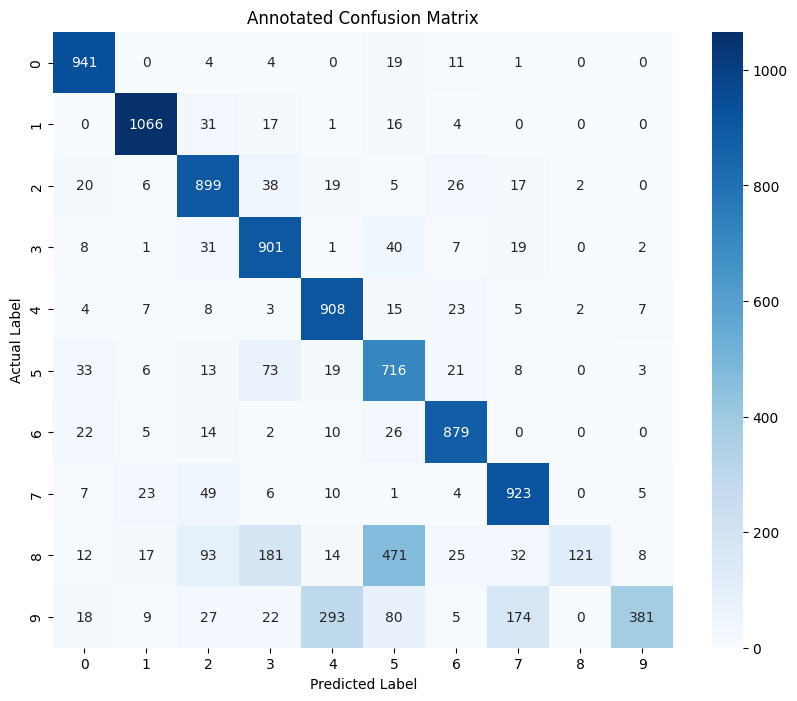

[CLEAN] Accuracy: 0.7735


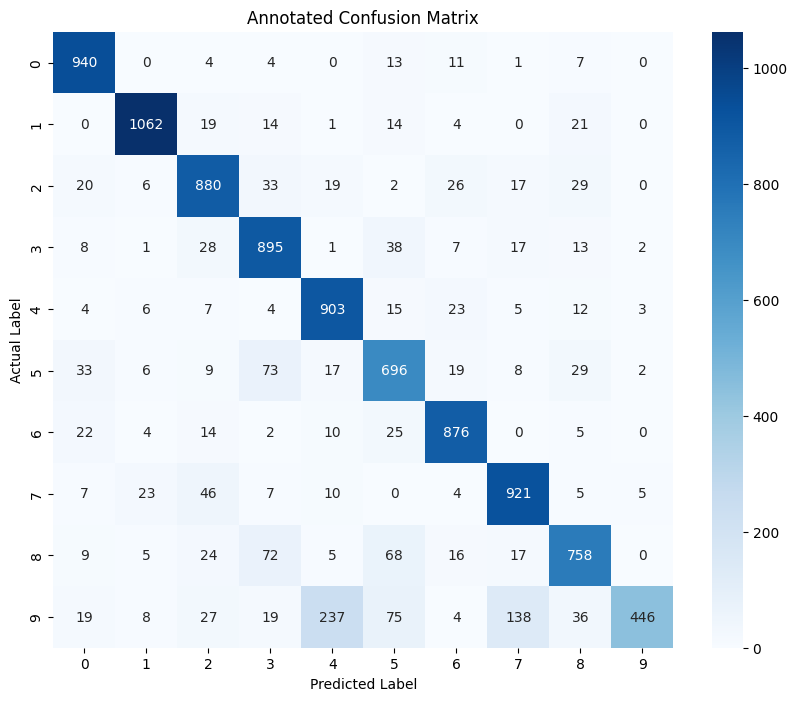

[POCKET] Accuracy: 0.8377


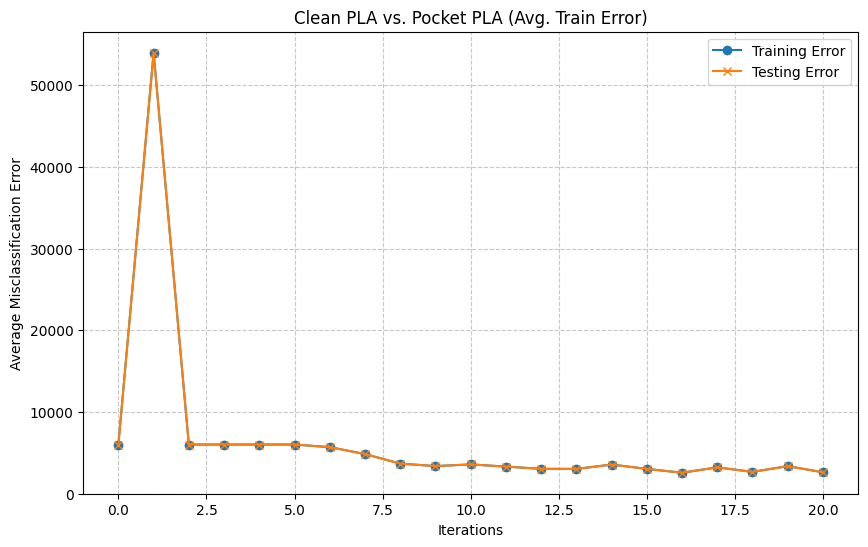

In [4]:
import numpy as np
from core.logger.config import logger
from core.analysis.evaluation_functions import evaluate_model
from core.analysis.plotting import plot_error_curves

classes = list(range(10))  # Digits 0..9
plot_dir_clean = "results/perceptron_results/clean"
plot_dir_pocket = "results/perceptron_results/pocket"

# ========== Evaluate Clean PLA ==========
logger.info("=== Evaluating Clean PLA ===")
cm_clean, acc_clean, sens_clean = evaluate_model(
    model=clean_perceptron, 
    X=X_test, 
    y=y_test, 
    classes=classes, 
    plot_dir=plot_dir_clean
)
print(f"[CLEAN] Accuracy: {acc_clean:.4f}")

# ========== Evaluate Pocket PLA ==========
logger.info("=== Evaluating Pocket PLA ===")
cm_pocket, acc_pocket, sens_pocket = evaluate_model(
    model=pocket_perceptron, 
    X=X_test, 
    y=y_test, 
    classes=classes, 
    plot_dir=plot_dir_pocket
)
print(f"[POCKET] Accuracy: {acc_pocket:.4f}")

# ================== Plot Training Error Curves ==================
def aggregate_iteration_losses(mcp):
    """
    Aggregates iteration-level train/test losses across all digits
    into an overall 'train_curve' and 'test_curve' by averaging.
    """
    num_classes = mcp.num_classes
    max_len = 0
    for cls_idx in range(num_classes):
        length_i = len(mcp.loss_history[cls_idx]["train"])
        if length_i > max_len:
            max_len = length_i
    
    all_train = []
    for cls_idx in range(num_classes):
        t_arr = mcp.loss_history[cls_idx]["train"][:]
        
        # If the classifier converged earlier, pad with the last value
        if len(t_arr) < max_len and len(t_arr) > 0:
            t_arr += [t_arr[-1]] * (max_len - len(t_arr))
        elif len(t_arr) == 0:
            t_arr = [0] * max_len
        
        all_train.append(t_arr)
    
    all_train = np.array(all_train)  # shape (num_classes, max_len)
    train_curve = np.mean(all_train, axis=0)  # shape (max_len,)

    return train_curve

logger.info("=== Plotting Average Training Curves for Clean vs Pocket PLA ===")

clean_train_curve = aggregate_iteration_losses(clean_perceptron)
pocket_train_curve = aggregate_iteration_losses(pocket_perceptron)

plot_error_curves(
    train_curve=clean_train_curve, 
    test_curve=pocket_train_curve,
    title="Clean PLA vs. Pocket PLA (Avg. Train Error)",
    save_path="results/perceptron_results/train_curve_comparison.png"
)



## 4. Visualize Training Error Curves

Each digit-specific classifier within `MultiClassPerceptron` stores iteration-level training errors. We'll **aggregate** them across all digits to create an average training curve. This provides a high-level overview of how the algorithm's error evolves over time.


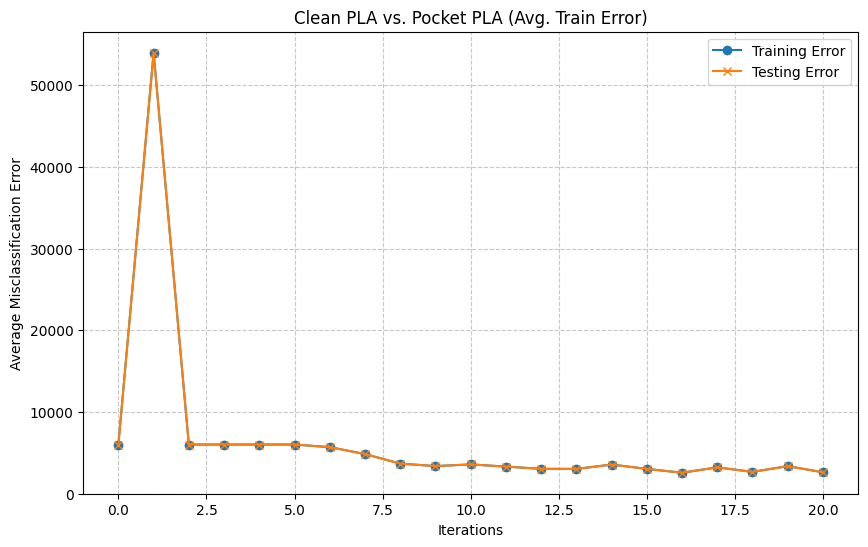

In [5]:
from core.logger.config import logger
from core.analysis.plotting import plot_error_curves
import numpy as np

def aggregate_iteration_losses(mcp):
    """
    Aggregates iteration-level train/test losses across all digits
    into an overall 'train_curve' and 'test_curve' by averaging.
    """
    num_classes = mcp.num_classes
    
    # Find the max iteration length among all digits
    max_len = 0
    for cls_idx in range(num_classes):
        length_i = len(mcp.loss_history[cls_idx]["train"])
        if length_i > max_len:
            max_len = length_i
    
    # Pad and sum
    all_train = []
    for cls_idx in range(num_classes):
        t_arr = mcp.loss_history[cls_idx]["train"][:]
        
        # If the classifier converged earlier, pad with last value
        if len(t_arr) < max_len:
            t_arr += [t_arr[-1]] * (max_len - len(t_arr))
        
        all_train.append(t_arr)
    
    # Convert to numpy, compute mean
    all_train = np.array(all_train)  # shape (num_classes, max_len)
    train_curve = np.mean(all_train, axis=0)  # shape (max_len,)

    # Return average train curve (No test curve stored in this example)
    return train_curve

logger.info("=== Plotting Average Training Curves for Clean vs Pocket PLA ===")

clean_train_curve = aggregate_iteration_losses(clean_perceptron)
pocket_train_curve = aggregate_iteration_losses(pocket_perceptron)

plot_error_curves(
    train_curve=clean_train_curve, 
    test_curve=pocket_train_curve,
    title="Clean PLA vs. Pocket PLA (Avg. Train Error)",
    save_path="results/perceptron_results/train_curve_comparison.png"
)


In [7]:
from IPython.display import display, Markdown
import numpy as np

# Assuming these variables exist from the evaluation step
acc_clean_str = f"{acc_clean * 100:.2f}%"
acc_pocket_str = f"{acc_pocket * 100:.2f}%"
sens_clean_str = f"{np.mean(sens_clean) * 100:.2f}%"
sens_pocket_str = f"{np.mean(sens_pocket) * 100:.2f}%"

# Dynamically format the table
summary_table = f"""
## Final Results Summary

| Metric                           | PLA Clean          | PLA Pocket         |
|----------------------------------|--------------------|--------------------|
| **Overall Accuracy**             | {acc_clean_str.ljust(18)} | {acc_pocket_str.ljust(18)} |
| **Average Sensitivity (TPR)**    | {sens_clean_str.ljust(18)} | {sens_pocket_str.ljust(18)} |

### Observations:
- Pocket PLA generally maintains or improves performance thanks to storing the best-performing weights.
- Both methods converged relatively quickly for MNIST data, indicating near-linearly separable conditions for many digits.
- Additional improvements might come from more advanced methods or hyperparameter tuning.

### Choice of `max_iter = 20`:
- The iteration limit was set to **20**.
- Higher values (e.g., 1000) might lead to marginal improvements but significantly increase computation time.
- The task requirement suggested that training should complete within **a few minutes**, which `max_iter = 20` satisfies very much speedwize but we can be more accurate with more iteration while keeping on a reasobable running time.

### Recommendations for Future Work:
- Investigate performance variations for different values of `max_iter` or alternative update rules.
- Compare results with logistic or linear regression models on the same dataset.
- Evaluate the effect of noise or partial occlusion on classification robustness.
"""

# Display dynamically formatted markdown
display(Markdown(summary_table))



## Final Results Summary

| Metric                           | PLA Clean          | PLA Pocket         |
|----------------------------------|--------------------|--------------------|
| **Overall Accuracy**             | 77.35%             | 83.77%             |
| **Average Sensitivity (TPR)**    | 77.07%             | 83.64%             |

### Observations:
- Pocket PLA generally maintains or improves performance thanks to storing the best-performing weights.
- Both methods converged relatively quickly for MNIST data, indicating near-linearly separable conditions for many digits.
- Additional improvements might come from more advanced methods or hyperparameter tuning.

### Choice of `max_iter = 20`:
- The iteration limit was set to **20**.
- Higher values (e.g., 1000) might lead to marginal improvements but significantly increase computation time.
- The task requirement suggested that training should complete within **a few minutes**, which `max_iter = 20` satisfies very much speedwize but we can be more accurate with more iteration while keeping on a reasobable running time.

### Recommendations for Future Work:
- Investigate performance variations for different values of `max_iter` or alternative update rules.
- Compare results with logistic or linear regression models on the same dataset.
- Evaluate the effect of noise or partial occlusion on classification robustness.
